In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
X_test = pd.read_csv("./Dataset/Testing/CIC_IDS_2017_testX.csv")
y_test = pd.read_csv("./Dataset/Testing/CIC_IDS_2017_testY.csv")

In [4]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_test_scaled = scaler.fit_transform(X_test)
X_test_scaled

array([[8.08740501e-04, 7.10891637e-04, 4.57337291e-06, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.22074038e-03, 8.59988298e-03, 9.14674582e-06, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [5.71565905e-01, 5.66666643e-07, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [1.22074038e-03, 7.09986887e-02, 1.37201187e-05, ...,
        0.00000000e+00, 7.09981750e-02, 7.09981750e-02],
       [8.08740501e-04, 2.22499991e-06, 4.57337291e-06, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [4.98672445e-02, 1.14999995e-06, 9.14674582e-06, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [5]:
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))
X_test_reshaped

array([[[8.08740501e-04],
        [7.10891637e-04],
        [4.57337291e-06],
        ...,
        [0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00]],

       [[1.22074038e-03],
        [8.59988298e-03],
        [9.14674582e-06],
        ...,
        [0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00]],

       [[5.71565905e-01],
        [5.66666643e-07],
        [0.00000000e+00],
        ...,
        [0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00]],

       ...,

       [[1.22074038e-03],
        [7.09986887e-02],
        [1.37201187e-05],
        ...,
        [0.00000000e+00],
        [7.09981750e-02],
        [7.09981750e-02]],

       [[8.08740501e-04],
        [2.22499991e-06],
        [4.57337291e-06],
        ...,
        [0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00]],

       [[4.98672445e-02],
        [1.14999995e-06],
        [9.14674582e-06],
        ...,
        [0.00000000e+00],
        [0.0000

In [6]:
import tensorflow as tf

def f1_score(y_true, y_pred):
    y_pred = tf.round(y_pred)

    tp = tf.reduce_sum(tf.cast(y_true * y_pred, 'float32'))
    fp = tf.reduce_sum(tf.cast((1 - y_true) * y_pred, 'float32'))
    fn = tf.reduce_sum(tf.cast(y_true * (1 - y_pred), 'float32'))

    precision = tp / (tp + fp + 1e-7)
    recall = tp / (tp + fn + 1e-7)

    return 2 * (precision * recall) / (precision + recall + 1e-7)

In [7]:
column_names = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1-score', 'TN', 'FP', 'FN', 'TP', 'Time(s)']
df = pd.DataFrame(columns=column_names)
df

,Model,Accuracy,Precision,Recall,F1-score,TN,FP,FN,TP,Time(s)


In [8]:
from tensorflow.keras.models import load_model

cnn_model = load_model("./Models/Base_CNN.h5", custom_objects={"f1_score": f1_score})
lstm_model = load_model("./Models/Base_LSTM.h5", custom_objects={"f1_score": f1_score})
transformer_model = load_model("./Models/Base_Transformer_model_clean", compile=False)

In [9]:
from sklearn.metrics import confusion_matrix, classification_report
import time

start_time = time.perf_counter()
y_pred = (cnn_model.predict(X_test_reshaped) > 0.5).astype(int)
end_time = time.perf_counter()

elapsed_time = end_time - start_time

cm_cnn = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred, digits=4, output_dict=True)
print(classification_report(y_test, y_pred, digits=4))

25996/25996 [==============================] - 51s 2ms/step
              precision    recall  f1-score   support

           0     0.9990    0.9809    0.9899    691418
           1     0.9138    0.9954    0.9529    140446

    accuracy                         0.9834    831864
   macro avg     0.9564    0.9882    0.9714    831864
weighted avg     0.9847    0.9834    0.9837    831864



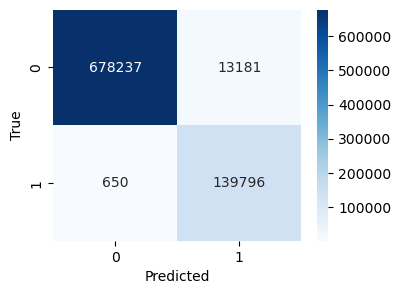

In [11]:
plt.figure(figsize=(4,3))
sns.heatmap(cm_cnn, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [12]:
df.loc[len(df)] = ['Base_CNN', report['accuracy'], report['weighted avg']['precision'], 
            report['weighted avg']['recall'], report['weighted avg']['f1-score'], cm_cnn[0][0], 
            cm_cnn[0][1], cm_cnn[1][0], cm_cnn[1][1], round(elapsed_time, 4)]
df

,Model,Accuracy,Precision,Recall,F1-score,TN,FP,FN,TP,Time(s)
0,Base_CNN,0.983373,0.984657,0.983373,0.983652,678237,13181,650,139796,59.4985


In [15]:
from sklearn.metrics import confusion_matrix, classification_report
import time

start_time = time.perf_counter()
y_pred = (lstm_model.predict(X_test_reshaped) > 0.5).astype(int)
end_time = time.perf_counter()

elapsed_time = end_time - start_time

cm_lstm = confusion_matrix(y_test, y_pred)
lstm_report = classification_report(y_test, y_pred, digits=4, output_dict=True)
print(classification_report(y_test, y_pred, digits=4))

25996/25996 [==============================] - 269s 10ms/step
              precision    recall  f1-score   support

           0     0.9920    0.9648    0.9782    691418
           1     0.8473    0.9619    0.9010    140446

    accuracy                         0.9643    831864
   macro avg     0.9197    0.9633    0.9396    831864
weighted avg     0.9676    0.9643    0.9652    831864



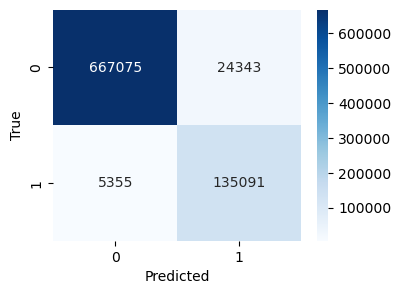

In [16]:
plt.figure(figsize=(4,3))
sns.heatmap(cm_lstm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [17]:
df.loc[len(df)] = ['Base_LSTM', lstm_report['accuracy'], lstm_report['weighted avg']['precision'], 
            lstm_report['weighted avg']['recall'], lstm_report['weighted avg']['f1-score'], cm_lstm[0][0], 
            cm_lstm[0][1], cm_lstm[1][0], cm_lstm[1][1], round(elapsed_time, 4)]
df

,Model,Accuracy,Precision,Recall,F1-score,TN,FP,FN,TP,Time(s)
0,Base_CNN,0.983373,0.984657,0.983373,0.983652,678237,13181,650,139796,59.4985
1,Base_LSTM,0.964299,0.967603,0.964299,0.965181,667075,24343,5355,135091,274.3433


In [18]:
X_test_3D  = np.expand_dims(X_test_reshaped, axis=-1)
X_test_3D.shape

(831864, 60, 1, 1)

In [86]:
start_time = time.perf_counter()
y_pred = (transformer_model.predict(X_test_reshaped) > 0.5).astype(int)
end_time = time.perf_counter()

elapsed_time = end_time - start_time

cm_transformer = confusion_matrix(y_test, y_pred)
transformer_report = classification_report(y_test, y_pred, digits=4, output_dict=True)
print(classification_report(y_test, y_pred, digits=4))

25996/25996 [==============================] - 605s 23ms/step
              precision    recall  f1-score   support

           0     0.9739    0.9544    0.9641    691418
           1     0.7957    0.8743    0.8331    140446

    accuracy                         0.9409    831864
   macro avg     0.8848    0.9143    0.8986    831864
weighted avg     0.9438    0.9409    0.9420    831864



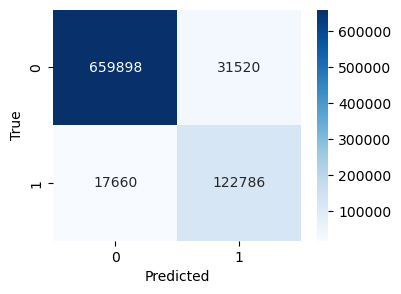

In [87]:
plt.figure(figsize=(4,3))
sns.heatmap(cm_transformer, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [88]:
df.loc[len(df)] = ['Base_Transformer', transformer_report['accuracy'], transformer_report['weighted avg']['precision'], 
            transformer_report['weighted avg']['recall'], transformer_report['weighted avg']['f1-score'], 
            cm_transformer[0][0], cm_transformer[0][1], cm_transformer[1][0], cm_transformer[1][1], round(elapsed_time, 4)]
df

,Model,Accuracy,Precision,Recall,F1-score,TN,FP,FN,TP,Time(s)
0,Base_CNN,0.983373,0.984657,0.983373,0.983652,678237,13181,650,139796,59.4985
1,Base_LSTM,0.964299,0.967603,0.964299,0.965181,667075,24343,5355,135091,274.3433
2,Base_Transformer,0.940880,0.943849,0.940880,0.941970,659898,31520,17660,122786,611.2996
3,Meta_Learner,0.981953,0.983538,0.981953,0.982291,676860,14558,455,139991,1.172358


In [23]:
df.to_csv("./Metrics/Base_model_Evaluation.csv", index=False)

In [27]:
from tqdm import tqdm
import tensorflow as tf

def mc_dropout_predict_batched(model, X, n_samples=10, batch_size=2048):
    """
    Perform MC Dropout predictions in batches to avoid OOM.

    Args:
        model: Keras model with dropout layers.
        X: Input data array.
        n_samples: Number of stochastic forward passes.
        batch_size: Size of batch for each forward pass.

    Returns:
        mean_pred: Mean prediction over MC samples [num_examples, 1]
        std_pred: Std deviation over MC samples [num_examples, 1]
    """
    predictions = []

    for _ in range(n_samples):
        batch_preds = []
        for i in range(0, len(X), batch_size):
            X_batch = X[i:i+batch_size]
            preds = model(X_batch, training=True)  # Dropout active
            batch_preds.append(preds.numpy())
        batch_preds = np.concatenate(batch_preds, axis=0)
        predictions.append(batch_preds)
    
    predictions = np.stack(predictions, axis=0)  # [n_samples, num_examples, 1]
    mean_pred = predictions.mean(axis=0)
    std_pred = predictions.std(axis=0)
    return mean_pred, std_pred

In [28]:
def generate_meta_features(base_models, X, n_samples=10, batch_size=2048):
    """
    Generate meta-features for ensemble training using MC Dropout.
    
    Args:
        base_models: list of Keras models [cnn_model, lstm_model, transformer_model]
        X: Input data array
        n_samples: MC Dropout forward passes
        batch_size: batch size to avoid memory issues

    Returns:
        meta_features: np.array of shape [num_examples, num_base_models]
        uncertainties: np.array of shape [num_examples, num_base_models]
    """
    meta_features = []
    uncertainties = []

    for model in base_models:
        mean_pred, std_pred = mc_dropout_predict_batched(model, X, n_samples=n_samples, batch_size=batch_size)
        meta_features.append(mean_pred)
        uncertainties.append(std_pred)
    
    meta_features = np.concatenate(meta_features, axis=1)  # shape: [num_examples, num_models]
    uncertainties = np.concatenate(uncertainties, axis=1)
    return meta_features, uncertainties

In [46]:
import tensorflow as tf
import numpy as np
import lightgbm as lgb

#Loading saved models
cnn_model = tf.keras.models.load_model("./Models/Pipeline/cnn_base.h5", custom_objects={"f1_score": f1_score})
lstm_model = tf.keras.models.load_model("./Models/Pipeline/lstm_base.h5", custom_objects={"f1_score": f1_score})
transformer_model = tf.keras.models.load_model("./Models/Pipeline/transformer_base", compile=False)

base_models = [cnn_model, lstm_model, transformer_model]

# Loading temperature
temperature = float(np.load("./Models/Pipeline/temperature_scale.npy")[0])

class TemperatureScaling(tf.keras.Model):
    def __init__(self, temperature):
        super().__init__()
        self.temperature = tf.Variable(temperature, dtype=tf.float32, trainable=False)
    def call(self, logits):
        return logits / self.temperature

temp_scaler = TemperatureScaling(temperature)

# Loading LightGBM meta-learner
meta_model = lgb.Booster(model_file="Models/Meta_LGBM.txt")

# Generating meta-features from base models
meta_X_test, meta_uncertainties_test = generate_meta_features(
    base_models,
    X_test_reshaped,
    n_samples=3,      
    batch_size=1024  
)

# Applying Temperature Scaling
meta_X_test_scaled = temp_scaler(meta_X_test).numpy()

In [54]:
# y_pred = meta_model.predict(meta_X_test_scaled)

start_time = time.perf_counter()
y_pred = (meta_model.predict(meta_X_test_scaled) > 0.5).astype(int)
end_time = time.perf_counter()

elapsed_time = end_time - start_time

cm_meta_learner = confusion_matrix(y_test, y_pred)
meta_learner_report = classification_report(y_test, y_pred, digits=4, output_dict=True)
print(classification_report(y_test, y_pred, digits=4))

# print("Final prediction probabilities:", y_pred)

              precision    recall  f1-score   support

           0     0.9993    0.9789    0.9890    691418
           1     0.9058    0.9968    0.9491    140446

    accuracy                         0.9820    831864
   macro avg     0.9526    0.9879    0.9691    831864
weighted avg     0.9835    0.9820    0.9823    831864



In [57]:
meta_learner_report['accuracy']

0.9819525787869171

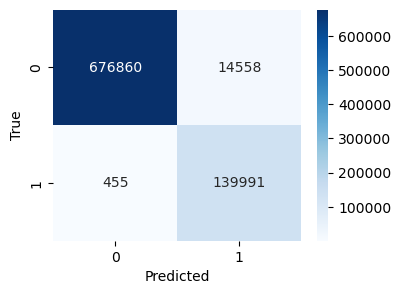

In [58]:
plt.figure(figsize=(4,3))
sns.heatmap(cm_meta_learner, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [59]:
['Meta_learner', meta_learner_report['accuracy'], meta_learner_report['weighted avg']['precision'], 
            meta_learner_report['weighted avg']['recall'], meta_learner_report['weighted avg']['f1-score'], 
            cm_meta_learner[0][0], cm_meta_learner[0][1], cm_meta_learner[1][0], cm_meta_learner[1][1], elapsed_time]

['Meta_learner',
 0.9819525787869171,
 0.9835381523391556,
 0.9819525787869171,
 0.9822910031302248,
 676860,
 14558,
 455,
 139991,
 1.1723581000042032]

In [92]:
df.loc[len(df)] = ['Meta_Learner', meta_learner_report['accuracy'], meta_learner_report['weighted avg']['precision'], 
            meta_learner_report['weighted avg']['recall'], meta_learner_report['weighted avg']['f1-score'], 
            cm_meta_learner[0][0], cm_meta_learner[0][1], cm_meta_learner[1][0], cm_meta_learner[1][1], elapsed_time]
df

,Model,Accuracy,Precision,Recall,F1-score,TN,FP,FN,TP,Time(s)
0,Base_CNN,0.983373,0.984657,0.983373,0.983652,678237,13181,650,139796,59.4985
1,Base_LSTM,0.964299,0.967603,0.964299,0.965181,667075,24343,5355,135091,274.3433
2,Base_Transformer,0.940880,0.943849,0.940880,0.941970,659898,31520,17660,122786,611.2996
3,Meta_Learner,0.981953,0.983538,0.981953,0.982291,676860,14558,455,139991,1.172358


In [70]:
df.to_csv("./Metrics/Base_model_Evaluation.csv", index=False)

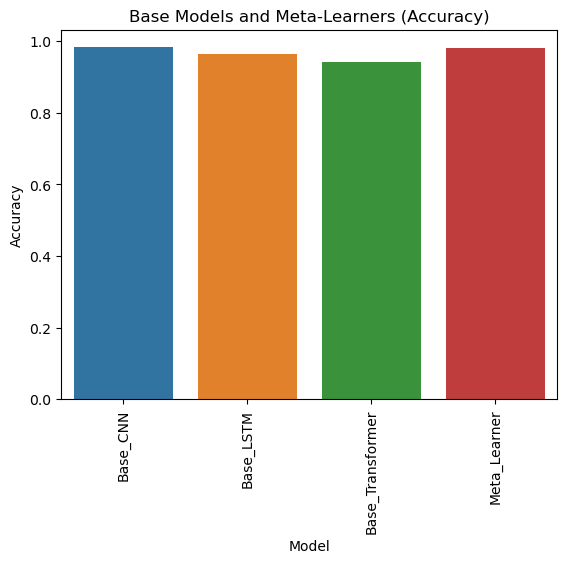

In [77]:
# plt.subplots(figsize=(3,3))
sns.barplot(x="Model", y="Accuracy",data=df)
plt.xticks(rotation=90)
plt.title('Base Models and Meta-Learners (Accuracy)')
plt.show()

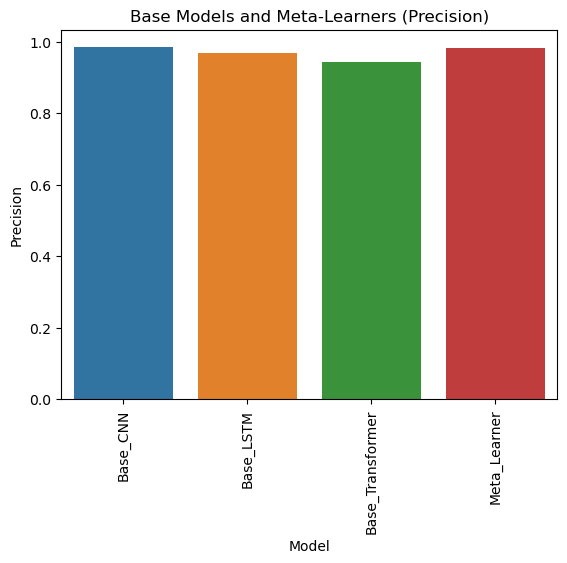

In [78]:
sns.barplot(x="Model", y="Precision",data=df)
plt.xticks(rotation=90)
plt.title('Base Models and Meta-Learners (Precision)')
plt.show()

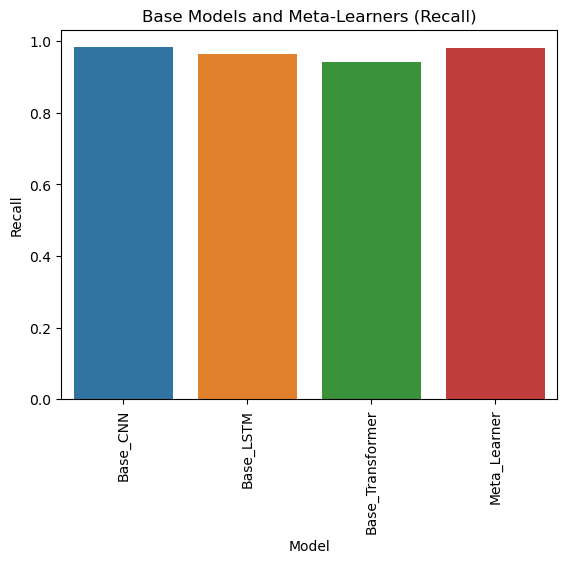

In [80]:
sns.barplot(x="Model", y="Recall",data=df)
plt.xticks(rotation=90)
plt.title('Base Models and Meta-Learners (Recall)')
plt.show()

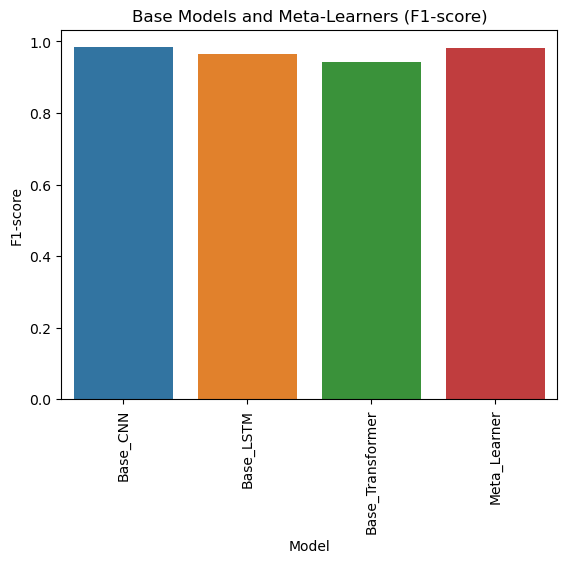

In [79]:
sns.barplot(x="Model", y="F1-score",data=df)
plt.xticks(rotation=90)
plt.title('Base Models and Meta-Learners (F1-score)')
plt.show()

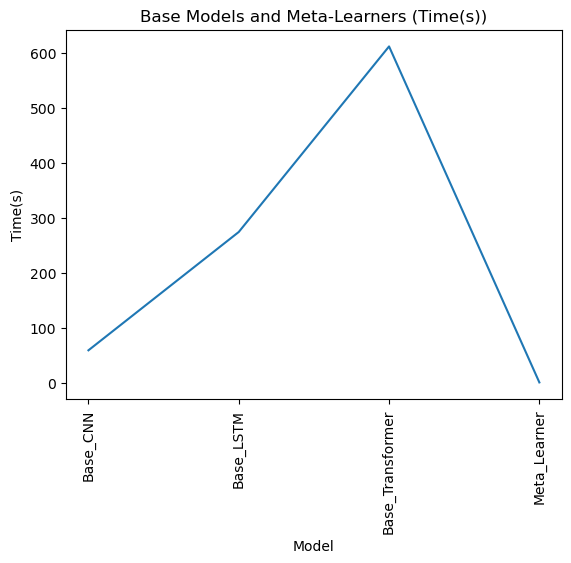

In [89]:
# plt.subplots(figsize=(3,3))
sns.lineplot(x="Model", y="Time(s)",data=df)
plt.xticks(rotation=90)

plt.title('Base Models and Meta-Learners (Time(s))')
plt.show()